<a href="https://colab.research.google.com/github/shantam21/Deep-Learning-Samples/blob/master/Tensorflow2/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Use seaborn for pairplot
!pip install seaborn

# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-gweak1pk
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-gweak1pk
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0dcf6d428a23727780cedcb671ebd9791b1b6f106_-cp36-none-any.whl size=133393 sha256=9802e5b38cdb56a8129d1d5195a128312d12ab9d1bce109812d086e5de1939e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-v5g5yg3p/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [7]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [8]:
#  check for nulls and drop them 
dataset.isna().sum()
dataset = dataset.dropna()

In [9]:
#  one-hot encoding for categorical values
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [10]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [11]:
#  train-test split
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

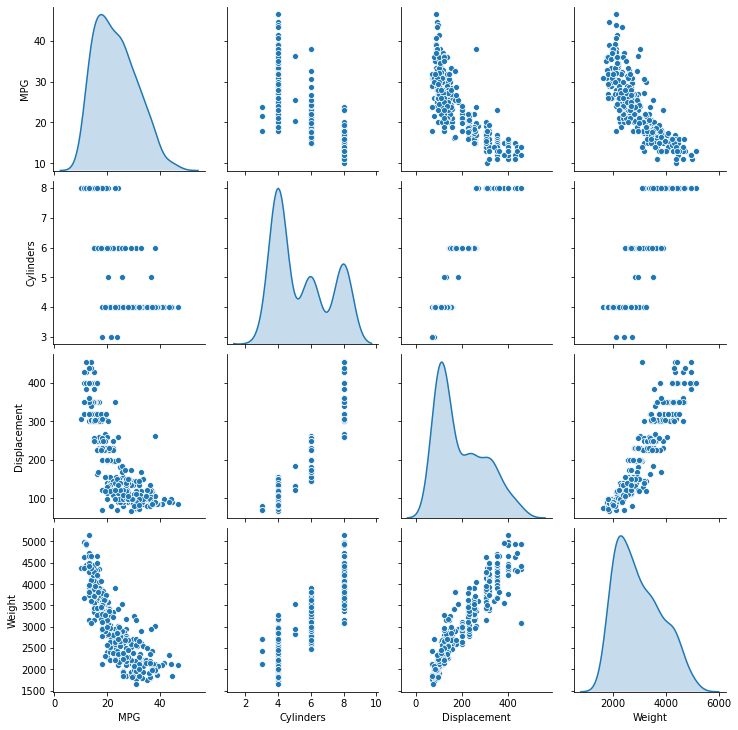

In [12]:
#  a look at the pairplots for understanding correlations 
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [13]:
# complete stats
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [15]:
# noemalize the data (essential for regreesion)
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [33]:
# model building
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [34]:
model = build_model()

In [35]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.0639636 ],
       [-0.0561864 ],
       [ 0.0111101 ],
       [ 0.04458806],
       [ 0.2524438 ],
       [ 0.00348173],
       [ 0.26985526],
       [-0.1583258 ],
       [-0.00171369],
       [ 0.41014487]], dtype=float32)

In [36]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:559.6734,  mae:22.3347,  mse:559.6734,  val_loss:534.5701,  val_mae:21.6818,  val_mse:534.5701,  
....................................................................................................
Epoch: 100, loss:5.7534,  mae:1.6845,  mse:5.7534,  val_loss:8.9159,  val_mae:2.3124,  val_mse:8.9159,  
....................................................................................................
Epoch: 200, loss:4.5709,  mae:1.4576,  mse:4.5709,  val_loss:9.3443,  val_mae:2.2536,  val_mse:9.3443,  
....................................................................................................
Epoch: 300, loss:3.7941,  mae:1.3321,  mse:3.7941,  val_loss:8.8060,  val_mae:2.2010,  val_mse:8.8060,  
....................................................................................................
Epoch: 400, loss:3.5589,  mae:1.3262,  mse:3.5589,  val_loss:9.1217,  val_mae:2.2403,  val_mse:9.1217,  
..............................................................

In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,1.938141,0.968974,1.938141,15.235539,2.896610,15.235539,995
996,1.763323,0.921610,1.763323,16.809864,3.194378,16.809864,996
997,1.491139,0.836976,1.491139,17.543186,2.986271,17.543186,997
998,2.035007,1.067022,2.035007,16.624706,3.058568,16.624706,998
999,1.429146,0.822221,1.429146,15.700468,2.949167,15.700468,999


# **Plotting**

In [38]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

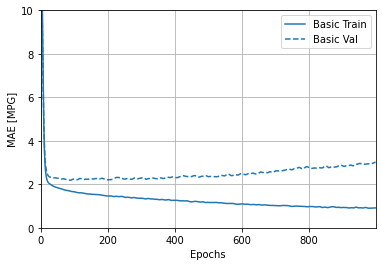

In [39]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

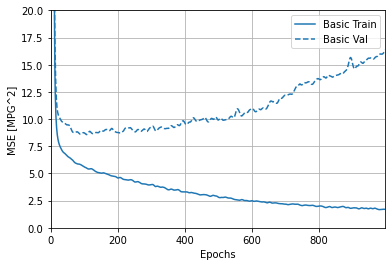

In [40]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [41]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:587.8944,  mae:23.0236,  mse:587.8944,  val_loss:596.4857,  val_mae:23.1653,  val_mse:596.4857,  
.......................................................................................

Text(0, 0.5, 'MAE [MPG]')

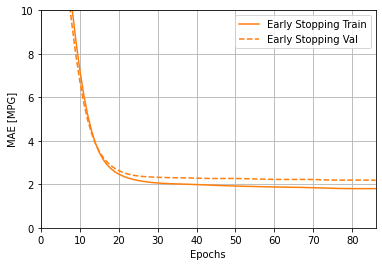

In [42]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [43]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.8256 - mae: 1.9058 - mse: 5.8256
Testing set Mean Abs Error:  1.91 MPG


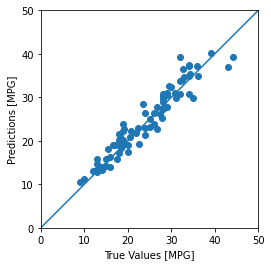

In [44]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


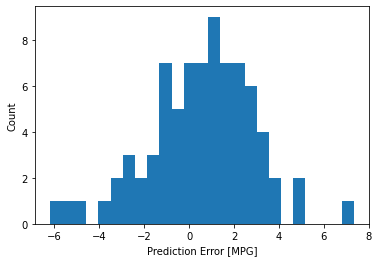

In [45]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")